In [17]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision  
import matplotlib.pyplot as plt


In [19]:
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary())

In [18]:

EPOCH =50  
BATCH_SIZE =100  
LR = 0.001  


In [19]:
# EMNIST 手写字母 训练集
train_data = torchvision.datasets.EMNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download = False,
    split = 'letters' 
)
# EMNIST 手写字母 测试集
test_data = torchvision.datasets.EMNIST(
    root='./data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=False,
    split = 'letters'     
)

In [20]:
# 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, 
                               batch_size=BATCH_SIZE,
                               shuffle=True)

test_loader = Data.DataLoader(dataset=test_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False)


# shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000] / 255.   
test_y = test_data.targets[:2000]
test_x = test_x.cuda() 
test_y = test_y.cuda() 

In [6]:
test_x.shape

torch.Size([2000, 1, 28, 28])

In [7]:
test_loader.dataset.data.shape

torch.Size([20800, 28, 28])

In [21]:
# 定义神经网络
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,  # 输入通道数
                out_channels=16,  # 输出通道数
                kernel_size=5,   # 卷积核大小
                stride=1,  #卷积步数
                padding=2,  # 如果想要 con2d 出来的图片长宽没有变化, 
                            # padding=(kernel_size-1)/2 当 stride=1
            ),  # output shape (16, 28, 28)
            
            nn.ReLU(),  # activation
            nn.MaxPool2d(kernel_size=2),  # 在 2x2 空间里向下采样, output shape (16, 14, 14)
        )
        
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        
        self.out = nn.Linear(32 * 7 * 7, 37)  # 全连接层，A/Z,a/z一共37个类

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # 展平多维的卷积图成 (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output
    

In [22]:
# 定义模型
cnn = CNN() 
cnn = cnn.cuda() 

# 损失函数和优化算法
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)  # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()  # the target label is not one-hotted


In [23]:
train_loss = []
accuracy_list = []
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):  # 每一步 loader 释放50个数据用来学习
        b_x = b_x.cuda() 
        b_y = b_y.cuda() 
        output = cnn(b_x)  # 输入一张图片进行神经网络训练
        loss = loss_func(output, b_y)  # 计算神经网络的预测值与实际的误差
        optimizer.zero_grad() #将所有优化的torch.Tensors的梯度设置为零
        loss.backward()  # 反向传播的梯度计算
        optimizer.step()  # 执行单个优化步骤
        if step % 100 == 0: # 每100步来查看一下神经网络训练的结果
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
            accuracy = float((pred_y == test_y).sum()) / float(test_y.size(0))

            accuracy_list.append(accuracy)
            print('Epoch: ', epoch+1, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            #print('Epoch: ', epoch, '| train loss: %.4f' % loss.data)
            train_loss.append(loss.data.cpu())

Epoch:  1 | train loss: 3.6286 | test accuracy: 0.00
Epoch:  1 | train loss: 0.8616 | test accuracy: 0.67
Epoch:  1 | train loss: 0.7235 | test accuracy: 0.75
Epoch:  1 | train loss: 0.4904 | test accuracy: 0.82
Epoch:  1 | train loss: 0.4039 | test accuracy: 0.78
Epoch:  1 | train loss: 0.3303 | test accuracy: 0.85
Epoch:  1 | train loss: 0.5249 | test accuracy: 0.91
Epoch:  1 | train loss: 0.4403 | test accuracy: 0.89
Epoch:  1 | train loss: 0.2198 | test accuracy: 0.88
Epoch:  1 | train loss: 0.2324 | test accuracy: 0.90
Epoch:  1 | train loss: 0.4735 | test accuracy: 0.91
Epoch:  1 | train loss: 0.2425 | test accuracy: 0.93
Epoch:  1 | train loss: 0.4311 | test accuracy: 0.90
Epoch:  2 | train loss: 0.2592 | test accuracy: 0.92
Epoch:  2 | train loss: 0.2847 | test accuracy: 0.91
Epoch:  2 | train loss: 0.2239 | test accuracy: 0.91
Epoch:  2 | train loss: 0.4455 | test accuracy: 0.94
Epoch:  2 | train loss: 0.2487 | test accuracy: 0.93
Epoch:  2 | train loss: 0.2793 | test accuracy

Epoch:  12 | train loss: 0.0810 | test accuracy: 0.94
Epoch:  12 | train loss: 0.2943 | test accuracy: 0.95
Epoch:  13 | train loss: 0.1441 | test accuracy: 0.94
Epoch:  13 | train loss: 0.1769 | test accuracy: 0.95
Epoch:  13 | train loss: 0.0677 | test accuracy: 0.95
Epoch:  13 | train loss: 0.1725 | test accuracy: 0.95
Epoch:  13 | train loss: 0.1194 | test accuracy: 0.95
Epoch:  13 | train loss: 0.2181 | test accuracy: 0.95
Epoch:  13 | train loss: 0.2022 | test accuracy: 0.96
Epoch:  13 | train loss: 0.1384 | test accuracy: 0.93
Epoch:  13 | train loss: 0.0751 | test accuracy: 0.94
Epoch:  13 | train loss: 0.1791 | test accuracy: 0.95
Epoch:  13 | train loss: 0.1340 | test accuracy: 0.94
Epoch:  13 | train loss: 0.1242 | test accuracy: 0.94
Epoch:  13 | train loss: 0.1418 | test accuracy: 0.94
Epoch:  14 | train loss: 0.0951 | test accuracy: 0.95
Epoch:  14 | train loss: 0.0765 | test accuracy: 0.95
Epoch:  14 | train loss: 0.1372 | test accuracy: 0.95
Epoch:  14 | train loss: 0.0

Epoch:  24 | train loss: 0.0471 | test accuracy: 0.94
Epoch:  24 | train loss: 0.0519 | test accuracy: 0.95
Epoch:  24 | train loss: 0.0594 | test accuracy: 0.93
Epoch:  24 | train loss: 0.0644 | test accuracy: 0.95
Epoch:  24 | train loss: 0.0396 | test accuracy: 0.94
Epoch:  24 | train loss: 0.0964 | test accuracy: 0.95
Epoch:  25 | train loss: 0.0838 | test accuracy: 0.94
Epoch:  25 | train loss: 0.0826 | test accuracy: 0.94
Epoch:  25 | train loss: 0.0510 | test accuracy: 0.95
Epoch:  25 | train loss: 0.1306 | test accuracy: 0.93
Epoch:  25 | train loss: 0.0684 | test accuracy: 0.92
Epoch:  25 | train loss: 0.0898 | test accuracy: 0.93
Epoch:  25 | train loss: 0.0728 | test accuracy: 0.94
Epoch:  25 | train loss: 0.0468 | test accuracy: 0.95
Epoch:  25 | train loss: 0.0578 | test accuracy: 0.94
Epoch:  25 | train loss: 0.0481 | test accuracy: 0.94
Epoch:  25 | train loss: 0.0659 | test accuracy: 0.94
Epoch:  25 | train loss: 0.1169 | test accuracy: 0.94
Epoch:  25 | train loss: 0.1

Epoch:  36 | train loss: 0.0802 | test accuracy: 0.95
Epoch:  36 | train loss: 0.0367 | test accuracy: 0.95
Epoch:  36 | train loss: 0.0520 | test accuracy: 0.94
Epoch:  36 | train loss: 0.0614 | test accuracy: 0.94
Epoch:  36 | train loss: 0.1493 | test accuracy: 0.94
Epoch:  36 | train loss: 0.0428 | test accuracy: 0.94
Epoch:  36 | train loss: 0.0681 | test accuracy: 0.94
Epoch:  36 | train loss: 0.0848 | test accuracy: 0.94
Epoch:  36 | train loss: 0.0581 | test accuracy: 0.94
Epoch:  36 | train loss: 0.1139 | test accuracy: 0.94
Epoch:  37 | train loss: 0.0665 | test accuracy: 0.94
Epoch:  37 | train loss: 0.0602 | test accuracy: 0.94
Epoch:  37 | train loss: 0.0338 | test accuracy: 0.94
Epoch:  37 | train loss: 0.0308 | test accuracy: 0.94
Epoch:  37 | train loss: 0.0917 | test accuracy: 0.94
Epoch:  37 | train loss: 0.0325 | test accuracy: 0.93
Epoch:  37 | train loss: 0.0226 | test accuracy: 0.93
Epoch:  37 | train loss: 0.0458 | test accuracy: 0.94
Epoch:  37 | train loss: 0.0

Epoch:  47 | train loss: 0.0294 | test accuracy: 0.94
Epoch:  48 | train loss: 0.0558 | test accuracy: 0.93
Epoch:  48 | train loss: 0.0167 | test accuracy: 0.92
Epoch:  48 | train loss: 0.0802 | test accuracy: 0.95
Epoch:  48 | train loss: 0.0471 | test accuracy: 0.94
Epoch:  48 | train loss: 0.0494 | test accuracy: 0.95
Epoch:  48 | train loss: 0.0428 | test accuracy: 0.94
Epoch:  48 | train loss: 0.0438 | test accuracy: 0.95
Epoch:  48 | train loss: 0.0734 | test accuracy: 0.94
Epoch:  48 | train loss: 0.0869 | test accuracy: 0.94
Epoch:  48 | train loss: 0.0347 | test accuracy: 0.94
Epoch:  48 | train loss: 0.0616 | test accuracy: 0.93
Epoch:  48 | train loss: 0.0115 | test accuracy: 0.92
Epoch:  48 | train loss: 0.0613 | test accuracy: 0.93
Epoch:  49 | train loss: 0.0540 | test accuracy: 0.94
Epoch:  49 | train loss: 0.0429 | test accuracy: 0.93
Epoch:  49 | train loss: 0.0318 | test accuracy: 0.93
Epoch:  49 | train loss: 0.0534 | test accuracy: 0.95
Epoch:  49 | train loss: 0.1

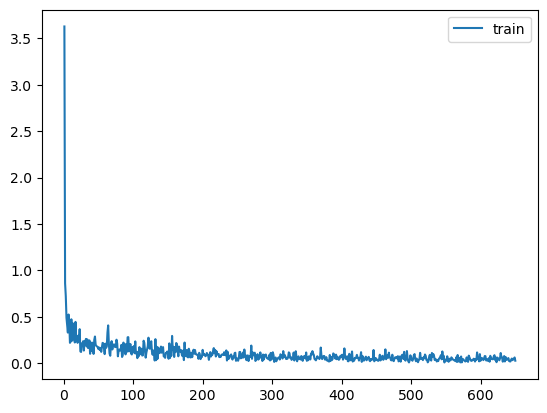

In [24]:
# 绘制loss曲线
import matplotlib.pyplot as plt


plt.plot([i for i in range(1, len(train_loss)+1)], train_loss, label="train")
plt.legend()
plt.show()

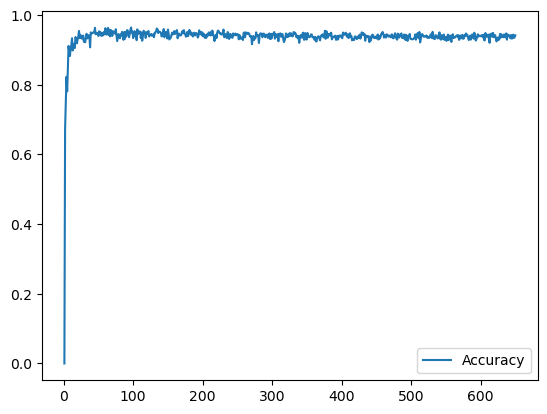

In [25]:
# 绘制准确率曲线
import matplotlib.pyplot as plt


plt.plot([i for i in range(1, len(accuracy_list)+1)], accuracy_list, label="Accuracy")
plt.legend()
plt.show()


In [26]:
# 模型测试部分
with torch.no_grad():
    correct = 0
    total = 0
    test_output = cnn(test_x)
    pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
    total = pred_y.size(0)
    correct += (test_y == pred_y).sum().item()
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total,))

Accuracy of the network on the 10000 test images: 94.5 %


In [27]:
# 保存模型
torch.save(cnn.state_dict(),'CNN_letter.pth')

In [28]:
import os
from PIL import Image
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# this function is for read image,the input is directory name
def read_directory(directory_name):
    # this loop is for read each image in this foder,directory_name is the foder name with images.
    file=open('E:/MyProject/digits/data.txt','w') 
    for filename in os.listdir(directory_name):
        #img is used to store the image data 
        img = Image.open(directory_name + "/" + filename)
        img = img.convert('L')  # 灰度化
        img_array = np.array(img)
        X_temp = np.array((255-img_array), dtype=float)
    
        print(filename)
        file.write(str(X_temp)); 
    file.close()

read_directory("E:/MyProject/digits/img2")

# 打开文件
f = open('E:/MyProject/digits/data.txt','r')
fs = f.readlines()
s = fs
f.close()

# 正则过滤非数字
for i in range(len(s)):
        s[i] = re.sub(r'\D', " ", s[i])
           
# 将 s 按空格拆分存到 spl 中   
sp = []
spl = [] 
for i in range(len(s)):
    sp = s[i].split()
    for j in range(len(sp)):
         spl.append(sp[j])
                   
arr= []
arr2 = []

# 按每784个一组，将spl中的数据存到arr2中
for l in range(int(len(spl)/784)):
    for i in range(784*l,784*(l+1)):
        arr.append(spl[i])
    
    arr2.append(arr)
    arr = []
    
# 将 arr2 转换为数组存入arr3
arr3=np.asarray(arr2)

A.jpg
B.jpg
C.jpg
D.jpg
E.jpg
F.jpg
G.jpg
H.jpg
I.jpg
J.jpg
K.jpg
L.jpg
M.jpg


In [29]:
def processing_CNN(img_input):
    device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
    
    arr3_mat = np.mat(img_input)
    arr3_mat = arr3_mat.astype(float)
    arr3_mat = arr3_mat.reshape(28,28)
    arr4 = torch.from_numpy(arr3_mat)
    img = arr4/255
    img = torch.unsqueeze(img,dim=0)
    img = torch.unsqueeze(img,dim=0)
    img = img.type(torch.FloatTensor)
    img_output = img.to(device)
    return img_output

In [30]:
def predict_CNN(arr3):
    y_predict = []
    for i in range(arr3.shape[0]):
        
        img = processing_CNN(arr3[i])
        
        
        with torch.no_grad():
            out1 = cnn(img)  
            predicted, index  = torch.max(out1, 1)
            degree = int(index[0])
            # print(predicted, degree)
            
            y_predict.append(degree)
            
    return y_predict

In [31]:
y_predict = predict_CNN(arr3)

In [32]:
y_predict_chr = [chr(64+i) for i in y_predict]
y_predict_chr

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'K', 'L', 'M']